## **PROJECT OD-1. Исследование каналов привлечения**
<font size="5" color="red"><b>DAPR-1016</b> Pidenko Dmitry</font>

### ЛЕГЕНДА
Продолжаем пробовать новые роли! На этот раз вы — маркетинговый аналитик в компании, предлагающей услуги клининга.

### ЗАДАНИЕ
*Предстоит сделать следующее:*

1.Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.

2.Определить, с каких источников и в какое время суток чаще всего заходят роботы.

*Период анализа: с 1 сентября 2020 года по 30 сентября 2020 года*

## *Подготавливаем данные*

<font size="5" color="yellow">Перед формированием параметров запроса импортируем библиотеки, которые понадобятся нам для работы:<b></font>

In [28]:
#В ответ на запрос от API приходят данные в формате json. Для работы с этим форматом нам понадобится библиотека Json.
import json 
#запрос мы будем делать не с помощью браузера, а через Python. Для этого  понадобится библиотека Requests.
import requests
#Импортируем библиотеку pprint, чтобы в более аккуратном виде отображать ответ от API.
from pprint import pprint
#Импортируем библиотеку Pandas и создаём датафрейм, для того чтобы обращаться с данными как с обычной таблицей.
import pandas as pd
#Библиотека matplotlib.pyplot подребуется для построения графиков 
import matplotlib.pyplot as plt


<font size="5" color="yellow">Следующим шагом нам нужно задать в переменной token в виде строки авторизационный токен, который мы получили ранее.<b></font>

In [29]:
#Теперь создадим переменную token, cодержащую авторизационный ключ (токен), который мы получили после регистрации приложения.
token = 'y0_AQAAAABjzbrxAAhSRgAAAADLeXue6m1bxVOZSMiw5nR6v6aekQcMVz8'
#Создадим словарь headers, содержащий одну пару ключ: значение
headers = {'Authorization': 'OAuth ' + token}

<font size="5" color="yellow">Зададим параметры для проведения анализа. Все параметры передадим в составе одного словаря. Назовём этот словарь params. <b></font>

In [30]:
#Находим в справочнике нужные метрики: ym:s:visits (общее количество визитов), ym:s:users (общее количество пользователей),
#ym:s:robotPercentage(доля роботов)
params = {'metrics': 'ym:s:visits,ym:s:users,ym:s:robotPercentage',
          
#Находим в справочнике нужный список группировок: ym:s:isRobot (Посетитель предположительно является роботом), 
#ym:s:<attribution>TrafficSource (Источник трафика) <attribution> - first — атрибуцию используем по первому источнику;
#ym:s:hour (Она группирует визиты по времени суток).
          'dimensions': 'ym:s:firstTrafficSource,ym:s:hour',
          
#Дата начала сбора статистики date1 — 2020-09-01.
          'date1': '2020-09-01', 
          
#Дата окончания сбора статистики date2 — 2020-09-30.
          'date2': '2020-09-30',  
          
#Номер счётчика, установленный на сайте ids - 30177909.  
          'ids': 30177909,
          
#Управлять точностью получаемых данных при запросе к API Яндекс.Метрики можно с помощью параметра accuracy, передав в него значение full
#Full означает, что берем данные по всем визитам для максимальной точности
          'accuracy':'full',
          
#Максимально допустимое количество строк в отчёте 'limit' - это ограничение на количество возвращаемых результатов. 
#По умолчанию он равен 100, поэтому важно указать число намного больше.
          'limit':100000}

<font size="5" color="yellow">После того как мы создали два словаря (один — для заголовков http, а другой — для параметров запроса) мы можем сделать запрос к API Метрики с помощью GET-запроса через библиотеку requests:. <b></font>

In [31]:
#Тип нашего запроса GET, его можно выполнить с помощью функции requests.get(). В неё мы передаём следующие параметры:
#URL, по которому будем делать запрос, в нашем случае — это 'https://api-metrika.yandex.net/stat/v1/data'.
#В аргументе params передаём заданные параметры запроса. Они хранятся в словаре params, который мы создали ранее.
#В аргументе headers передаем заголовки http, которые мы задали в словаре headers.
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)

# Строка print (response.status_code) нужна для того, чтобы возвратить код ответа, полученный от API. 
# Если этот код 200 — значит, запрос был составлен корректно и API передал ответ.
print (response.status_code)

200


<font size="5" color="yellow">Получить данные ответа можно с помощью функции json(), примененной к запросу response. Это позволяет сразу же распознать формат json и переделать ответ из этого формата в объект Python. <b></font>

In [32]:
#Запишем данные ответа в переменную metrika_data:
metrika_data = response.json()

In [33]:
#Посмотрим, какого типа данные хранятся в объекте metrika_data:
print(type(metrika_data))

<class 'dict'>


In [34]:
#Это словарь!Проверим, какие ключи есть в словаре metrika_data:
print(metrika_data.keys())

dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])


<font size="5" color="yellow">Прежде всего нас интересует значение по ключу data. Именно там содержатся данные статистики посещаемости, полученные от API Яндекс.Метрики. Но есть и другие полезные параметры, например total_rows. В нём содержится количество строк, которые соответствуют нашему запросу: <b></font>

In [35]:
#Посмотрим на данные статистики. Для этого с помощью pprint выведем значение по ключу data в словаре metrika_data:
pprint(metrika_data['data'][0:5])

[{'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '16', 'name': '16:00'}],
  'metrics': [248.0, 241.0, 25.40322581]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '15', 'name': '15:00'}],
  'metrics': [237.0, 231.0, 26.58227848]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '12', 'name': '12:00'}],
  'metrics': [224.0, 209.0, 25.44642857]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '13', 'name': '13:00

<font size="5" color="yellow">Далее будем работать с библиотекой pandas. Есть небольшая проблема в том, что dimensions содержит в себе список словарей: мы получаем словарь в словаре.Это достаточно сложная структура данных, которую по умолчанию Pandas не может преобразовать в удобную таблицу. Чтобы привести это к удобному для работы виду, сначала преобразуем данные в так называемый плоский вид, то есть избавимся от вложенных словарей. <b></font>

In [36]:
#Избавляемся от вложенных словарей при помощи функции
#Создаем функцию
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

<font size="5" color="yellow">Обратим внимание на использование функции enumerate(). Она позволяет сделать цикл по списку, при этом возвращая сам элемент списка, а также его индекс в этом списке. Это может быть удобно, если нужно сделать вывод информационного сообщения о количестве пройденных итераций цикла. Также эта функция бывает полезна, если нужно параллельно обращаться к соответствующему элементу другого списка, как в случае нашей функции getMetrikaDataInListOfDicts(). <b></font>

In [37]:
#Преобразуем наши данные с помощью этой функции и запишем в переменную metrika_list_of_dicts:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
pprint(metrika_list_of_dicts[0:5])

[{'ym:s:firstTrafficSource': 'Search engine traffic',
  'ym:s:hour': '16:00',
  'ym:s:robotPercentage': 25.40322581,
  'ym:s:users': 241.0,
  'ym:s:visits': 248.0},
 {'ym:s:firstTrafficSource': 'Search engine traffic',
  'ym:s:hour': '15:00',
  'ym:s:robotPercentage': 26.58227848,
  'ym:s:users': 231.0,
  'ym:s:visits': 237.0},
 {'ym:s:firstTrafficSource': 'Search engine traffic',
  'ym:s:hour': '12:00',
  'ym:s:robotPercentage': 25.44642857,
  'ym:s:users': 209.0,
  'ym:s:visits': 224.0},
 {'ym:s:firstTrafficSource': 'Search engine traffic',
  'ym:s:hour': '13:00',
  'ym:s:robotPercentage': 27.80269058,
  'ym:s:users': 208.0,
  'ym:s:visits': 223.0},
 {'ym:s:firstTrafficSource': 'Search engine traffic',
  'ym:s:hour': '14:00',
  'ym:s:robotPercentage': 25.11210762,
  'ym:s:users': 216.0,
  'ym:s:visits': 223.0}]


<font size="5" color="yellow">Итак, мы получили metrika_list_of_dicts. Значение этой переменной представляет собой обычный список словарей без вложенных объектов. Такая структура данных годится для того, чтобы из неё сделать датафрейм. <b></font>

In [38]:
#Создаем датафрейм. Для этого передадим metrika_list_of_dicts в функцию pd.DataFrame(), чтобы создать датафрейм metrika_df:
metrika_df = pd.DataFrame(metrika_list_of_dicts)
display(metrika_df.head(10))

,ym:s:firstTrafficSource,ym:s:hour,ym:s:visits,ym:s:users,ym:s:robotPercentage
0,Search engine traffic,16:00,248.0,241.0,25.403226
1,Search engine traffic,15:00,237.0,231.0,26.582278
2,Search engine traffic,12:00,224.0,209.0,25.446429
3,Search engine traffic,13:00,223.0,208.0,27.802691
4,Search engine traffic,14:00,223.0,216.0,25.112108
5,Search engine traffic,11:00,221.0,215.0,24.886878
6,Search engine traffic,17:00,200.0,190.0,26.500000
7,Search engine traffic,10:00,179.0,170.0,20.670391
8,Search engine traffic,21:00,161.0,152.0,16.770186
9,Search engine traffic,19:00,154.0,149.0,24.025974


In [39]:
#Для удобства переименуем столбцы.
metrika_df.columns = ['TRAFFIC SOURCE','TIME','VISITS','USERS','ROBOT PERCENTAGE']
display(metrika_df)

,TRAFFIC SOURCE,TIME,VISITS,USERS,ROBOT PERCENTAGE
0,Search engine traffic,16:00,248.0,241.0,25.403226
1,Search engine traffic,15:00,237.0,231.0,26.582278
2,Search engine traffic,12:00,224.0,209.0,25.446429
3,Search engine traffic,13:00,223.0,208.0,27.802691
4,Search engine traffic,14:00,223.0,216.0,25.112108
...,...,...,...,...,...
94,Social network traffic,07:00,1.0,1.0,0.000000
95,Social network traffic,11:00,1.0,1.0,0.000000
96,Social network traffic,16:00,1.0,1.0,0.000000
97,Recommendation system traffic,08:00,1.0,1.0,0.000000


<font size="5" color="yellow">Создадим два дополнительных столбца с людьми и роботами, для удобства <b></font>

In [40]:
#Создадим столбец с роботами и сразу произведем подчет их количества визитов за каждый определенный отрезок времени
metrika_df['ROBOTS'] = metrika_df['VISITS'] * metrika_df['ROBOT PERCENTAGE'] / 100
#Также создадим столбец с пользователями, найдем их количества за определенные промежутки времени 
metrika_df['PEOPLE'] = metrika_df['VISITS'] - metrika_df['ROBOTS']
#Выведем таблицу
metrika_df

,TRAFFIC SOURCE,TIME,VISITS,USERS,ROBOT PERCENTAGE,ROBOTS,PEOPLE
0,Search engine traffic,16:00,248.0,241.0,25.403226,63.0,185.0
1,Search engine traffic,15:00,237.0,231.0,26.582278,63.0,174.0
2,Search engine traffic,12:00,224.0,209.0,25.446429,57.0,167.0
3,Search engine traffic,13:00,223.0,208.0,27.802691,62.0,161.0
4,Search engine traffic,14:00,223.0,216.0,25.112108,56.0,167.0
...,...,...,...,...,...,...,...
94,Social network traffic,07:00,1.0,1.0,0.000000,0.0,1.0
95,Social network traffic,11:00,1.0,1.0,0.000000,0.0,1.0
96,Social network traffic,16:00,1.0,1.0,0.000000,0.0,1.0
97,Recommendation system traffic,08:00,1.0,1.0,0.000000,0.0,1.0


## *1.Оценим количество ботов, которые заходят на наш сайт, и их долю от всего трафика.*

In [41]:
#Произведем расчет метрик и выведим общую картину
print('Общее количество визитов всех пользователей:', round(metrika_df['VISITS'].sum()))
print('Общее количество визитов людей:', round(metrika_df['PEOPLE'].sum()))
print('Общее количество визитов роботов:', round(metrika_df['ROBOTS'].sum()))
print('Доля роботов в % от всех пользователей:', round(metrika_df['ROBOTS'].sum() / metrika_df['VISITS'].sum()*100,2))

Общее количество визитов всех пользователей: 4315
Общее количество визитов людей: 3353
Общее количество визитов роботов: 962
Доля роботов в % от всех пользователей: 22.29


In [42]:
#Создаем сводную таблицу посещений среди людей и роботов
pivot_df = metrika_df.pivot_table(
    index='TRAFFIC SOURCE',
    values=['ROBOTS', 'PEOPLE'],
    aggfunc='sum',
    fill_value=0
    )
pivot_df.reset_index()

,TRAFFIC SOURCE,PEOPLE,ROBOTS
0,Cached page traffic,3,1
1,Direct traffic,668,195
2,Internal traffic,3,0
3,Link traffic,95,30
4,Recommendation system traffic,2,0
5,Search engine traffic,2523,725
6,Social network traffic,59,11


<font size="5" color="yellow">Визуализируем данные <b></font>

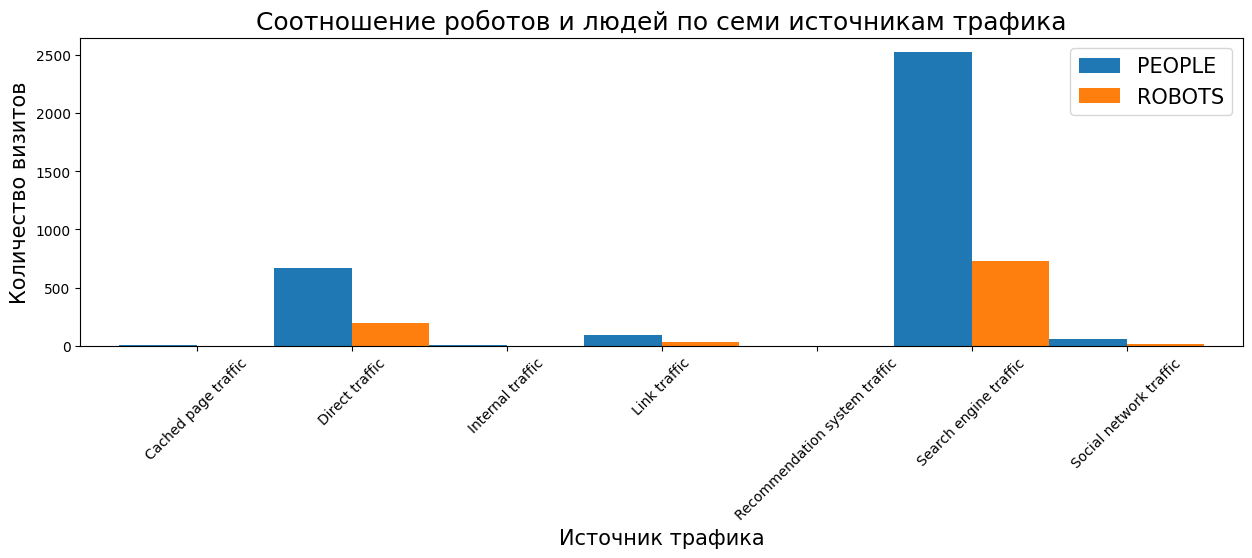

In [43]:
plt.rcParams['font.size'] = '15'#размер шрифта
pivot_df.plot(
    kind='bar',
    grid=False,#сетка
    rot=45,
    title='Соотношение роботов и людей по семи источникам трафика',
    ylabel='Количество визитов',
    xlabel='Источник трафика',
    width=1,#ширина столбцов 
    fontsize=10,
    figsize=(15, 4)
);

In [44]:
import plotly.graph_objects as go


labels = ['Search engine traffic','Direct traffic','Link traffic','Social network traffic']
values = [725,195,30,11]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='percent' )])#pull=[0, 0, 0, 0.4]
fig.update_layout(title_text='Распределение трафика роботов по источникам')
fig.show()

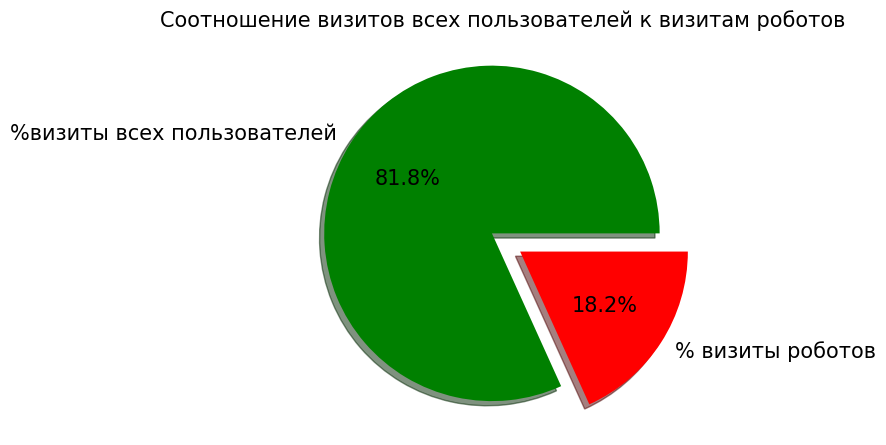

In [45]:
#создадим переменные для построения графика
total_visits = metrika_df['VISITS'].sum()
total_robots = metrika_df['ROBOTS'].sum()
#строим график
pivot_df = [total_visits, total_robots]
labels = ['%визиты всех пользователей', '% визиты роботов']
fig = plt.figure(figsize=(4,4))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    pivot_df, 
    labels = labels, 
    colors = ( "green", "red"),
    shadow = True,  
    autopct='%1.1f%%',
    #startangle=120, 
    explode = [0.2, 0])

axes.set_title('Соотношение визитов всех пользователей к визитам роботов ', fontsize=15)
plt.axis('equal')
plt.show()

## Вывод:
#### Произведен анализ посещений сайта за период с 01.09.2020 по 30.09.2020 г. Было выявлено, что за отведенный отрезок времени общее количество пользователей в том числи и роботов составило 4315 раз. Из них 962 раза произвели визиты роботы, их процентная доля составляет - 22.29% от всех пользователей.Остальные 3353 раза посетили люди, в процентах - 77.71%.

### Что касаемо источников трафика, то у роботов и у людей популярность каналов совпадает. Ниболее популярный источник 'Search engine traffic', а наимение популярный 'Recommendation system traffic'.

<font size="5" color="yellow">Подкорректируем таблицу <b></font>

In [46]:
#Копируем таблицу, на тот случай если что-то пойдет не так
metrika_df2 = metrika_df.copy()

In [47]:
#Строим сводную таблицу, для того чтобы выяснить: Сколько визитов осуществлялось роботами, по каждому трафику за разный промежуток времени
pivot2_df = metrika_df2.pivot_table(
  index = 'TIME',
  columns = 'TRAFFIC SOURCE',
  values = 'ROBOTS',
  aggfunc= 'sum', 
  fill_value = 0
)
pivot2_df

TRAFFIC SOURCE,Cached page traffic,Direct traffic,Internal traffic,Link traffic,Recommendation system traffic,Search engine traffic,Social network traffic
TIME,,,,,,,
00:00,0,2,0,0,0,17,0
01:00,1,4,0,0,0,8,0
02:00,0,2,0,0,0,5,0
03:00,0,2,0,1,0,3,0
04:00,0,3,0,0,0,3,0
05:00,0,3,0,0,0,1,0
06:00,0,3,0,2,0,3,0
07:00,0,5,0,1,0,6,0
08:00,0,6,0,1,0,28,1


In [48]:
#Произведем расчет приминив агрегированную функцию SUM()
pivot2_df.sum()

TRAFFIC SOURCE
Cached page traffic                1
Direct traffic                   195
Internal traffic                   0
Link traffic                      30
Recommendation system traffic      0
Search engine traffic            725
Social network traffic            11
dtype: int64

## *2.Определить, с каких источников и в какое время суток чаще всего заходят роботы.*

In [49]:
#Добавим к сформированной таблицы столбец и назовем его TOTAL TIME, в нем сосчитаем количество посещений за каждый час
pivot2_df['TOTAL TIME'] = pivot2_df.sum(axis=1)
pivot2_df

TRAFFIC SOURCE,Cached page traffic,Direct traffic,Internal traffic,Link traffic,Recommendation system traffic,Search engine traffic,Social network traffic,TOTAL TIME
TIME,,,,,,,,
00:00,0,2,0,0,0,17,0,19
01:00,1,4,0,0,0,8,0,13
02:00,0,2,0,0,0,5,0,7
03:00,0,2,0,1,0,3,0,6
04:00,0,3,0,0,0,3,0,6
05:00,0,3,0,0,0,1,0,4
06:00,0,3,0,2,0,3,0,8
07:00,0,5,0,1,0,6,0,12
08:00,0,6,0,1,0,28,1,36


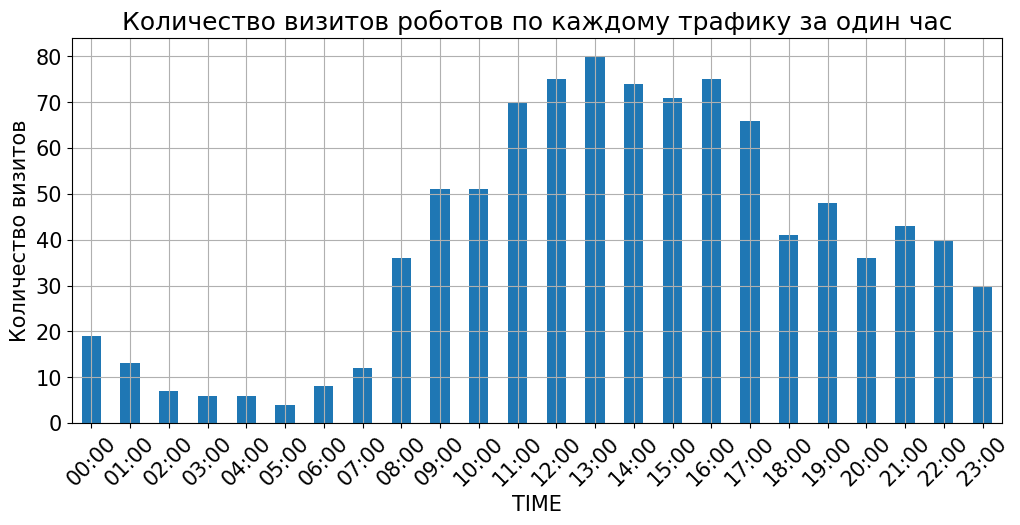

In [50]:
robots = pivot2_df.groupby('TIME')['TOTAL TIME'].sum()
robots.plot(
    kind='bar',
    figsize=(12, 5),
    title='Количество визитов роботов по каждому трафику за один час',
    ylabel='Количество визитов',
    grid = True,
    rot=45,
    #color='red',
    lw=3
);

## Вывод:
#### Наиболее активное время для посещения у роботов с 11:00 до 17:00. Пик посещаемости происходит в 13.00 дня (80 посещений) 
#### Менее всего сайт посещают роботы с 00:00 до 07:00. Отсюда можно заключить, что роботы предпочитают ночью спать.

<font size="5" color="yellow">Тренировочный график в plotly.express<b>

In [51]:
import plotly.express as px
robots = pivot2_df.groupby(by='TIME')[['TOTAL TIME']].sum()

#строим график
fig = px.bar(
    data_frame=robots, #DataFrame
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Количество визитов роботов по каждому трафику за один час' #заголовок
)

#отображаем график
fig.show()